In [2]:
from scipy import sparse
import pandas as pd
import numpy as np
import sys

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1

In [4]:
import dask.dataframe as dd
import scipy.io
import csv
import gzip
import os

matrix_dir='filtered_feature_bc_matrix'
mito_gene_list='mitochondrial.gene'
outfile='Microglia_MO_AD4'

mito_gene = np.loadtxt(mito_gene_list, dtype='str')
mito_gene_df = pd.DataFrame(data=np.ones(len(mito_gene)), index=mito_gene, columns=['mito'])

mat_path = os.path.join(matrix_dir, "matrix.mtx.gz")
mat      = dd.read_csv(mat_path, skiprows=[0,1,2], names=['igene','icb','umi'], \
sep=' ', compression='gzip')

features_path = os.path.join(matrix_dir, "features.tsv.gz")
feature_raw   = dd.read_csv(features_path,names=['gene','gene_name','type'],\
sep='\t',compression='gzip')

feature = dd.merge(feature_raw,mito_gene_df,left_on='gene',right_index=True,how='left')
feature['mito'] = feature['mito'].fillna(0)

barcodes_path = os.path.join(matrix_dir, "barcodes.tsv.gz")
barcodes      = dd.read_csv(barcodes_path,names=['cb'], sep="\t", compression='gzip')

n_feature = feature.shape[0].compute()
feature['igene'] = feature.index + 1
df_12 = dd.merge(feature, mat, on='igene')

n_barcode = barcodes.shape[0].compute()
barcodes['icb'] = barcodes.index + 1
df = dd.merge(df_12, barcodes, on='icb')
df['mito_umi'] = df['mito'] * df['umi']

cb_stat = df.groupby('cb').agg({'igene': ['count'],'umi':['sum'],'mito_umi':['sum']}).compute()

cb_stat.columns = ['num_gene','num_umi','mito_umi']
cb_stat['mito_percent'] = cb_stat['mito_umi'] / cb_stat['num_umi']
num_gene_mean = np.mean(cb_stat['num_gene'])
num_gene_std  = np.std(cb_stat['num_gene'])
num_umi_mean  = np.mean(cb_stat['num_umi'])
num_umi_std  = np.std(cb_stat['num_umi'])

select1 = abs(cb_stat['num_gene'] - num_gene_mean) < num_gene_std
select2 = abs(cb_stat['num_umi'] - num_umi_mean) < num_umi_std
select3 = cb_stat['mito_percent'] < 0.2
cb_stat['keep'] = 0
cb_stat.loc[select1 & select2 & select3,'keep'] = 1

cb_stat[['num_gene','num_umi','mito_percent','keep']].to_csv(outfile+'.qc')
# dense matrix
header=['cb','gene','umi']
df[header].to_csv('%s.mtx'%outfile,header=True,index=False,single_file = True)

/home/bxj139/.usr/local/python/3.7.0/lib/python3.7/site-packages/dask/dataframe/io/csv.py:387: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression


['/mnt/pan/Data14/ASEkinetics/Microglia_MO_AD4.mtx']

Text(0.5, 0, '# UMI')

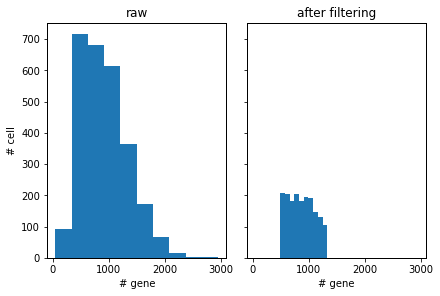

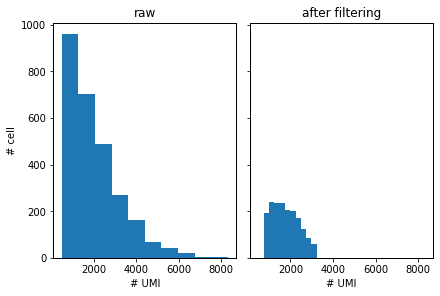

In [5]:
fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
ax[0].set_ylabel('# cell')
ax[0].hist(cb_stat['num_gene'])
ax[0].set_title('raw')
ax[0].set_xlabel('# gene')
ax[1].hist(cb_stat.loc[cb_stat['keep']==1,'num_gene'])
ax[1].set_title('after filtering')
ax[1].set_xlabel('# gene')

fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
ax[0].set_ylabel('# cell')
ax[0].hist(cb_stat['num_umi'])
ax[0].set_title('raw')
ax[0].set_xlabel('# UMI')
ax[1].hist(cb_stat.loc[cb_stat['keep']==1,'num_umi'])
ax[1].set_title('after filtering')
ax[1].set_xlabel('# UMI')

In [6]:
from lib.ase_infer import *
umi_file = 'Microglia_MO_AD4.mtx'
ase_file = 'ENSG00000118785.ase'
cb_file  = 'Microglia_MO_AD4.qc'
out_prefix  = 'Microglia_MO_AD4'

umi_raw = pd.read_csv(umi_file,dtype={'cb':str,'gene':str,'umi':float})
ase_raw = pd.read_csv(ase_file,dtype={'allele_ref':str,'ub_ref':float,'allele_alt':str,'ub_alt':float})
ase_raw['ub_alt'] = ase_raw['ub_alt'].fillna(0)
ase_raw['ub_ref'] = ase_raw['ub_ref'].fillna(0)

# filtered cells
cb_raw = pd.read_csv(cb_file,header=0)
cb_keep = cb_raw.loc[cb_raw['keep']==1]
umi = pd.merge(umi_raw, cb_keep, on='cb')
ase = pd.merge(ase_raw, cb_keep, on='cb')

out_file = '%s.ase.class'%(out_prefix)
ase_class = allele_class(ase,save=True,outfile=out_file)

ase_infer_file = '%s.ase'%(out_prefix)
allele_infer(umi,ase,ase_class,ase_infer_file)

In [7]:
ase_infer_file = 'Microglia_MO_AD4.ase.infer'
ase_infer = pd.read_csv(ase_infer_file,header=0)
ase_infer.head(5)

,cb,gene,pos,allele_ref,ub_ref,allele_alt,ub_alt,umi
0,CAAGTTGTCTACCTGC-1,ENSG00000118785,4:87982701,C,0.99,T,0.01,36.0
1,GGGTCTGCATGCAATC-1,ENSG00000118785,4:87982701,C,0.99,T,0.01,22.0
2,ATGTGTGCACCGCTAG-1,ENSG00000118785,4:87982701,C,0.99,T,0.01,96.0
3,GCAGCCAGTTTGACAC-1,ENSG00000118785,4:87982701,C,0.99,T,0.01,39.0
4,GCCTCTAGTACGCACC-1,ENSG00000118785,4:87982701,C,0.99,T,0.01,11.0


Text(0.5, 0, 'ase ratio')

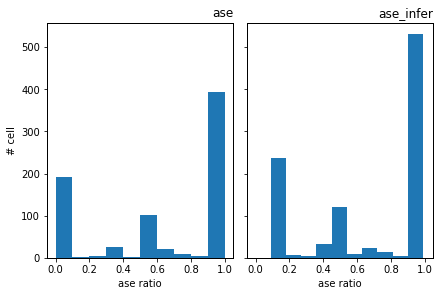

In [8]:
fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True,constrained_layout=True)
ax[0].hist(ase['ub_ref']/(ase['ub_ref']+ase['ub_alt']).round(5))
ax[0].set_title('ase',loc='right')
ax[0].set_xlabel('ase ratio')
ax[0].set_ylabel('# cell')
ax[1].hist(ase_infer['ub_ref'].round(5))
ax[1].set_title('ase_infer',loc='right')
ax[1].set_xlabel('ase ratio')

In [10]:
from lib.ase_reform import *

ase_sparse_mat, allele_list, cb_list = process(ase_infer)

cb_idx = pd.DataFrame(cb_list, columns=['cb'])
cb_idx.reset_index(inplace=True)
allele_idx = pd.DataFrame(allele_list, columns=['allele'])
allele_idx.reset_index(inplace=True)

In [11]:
from joblib import delayed,Parallel
from os import cpu_count
from lib.kpe import *

method='pb'
ase_mat = ase_sparse_mat.toarray()
data = Parallel(n_jobs=cpu_count())(delayed(est_vec)(vec,method) for i,vec in enumerate(ase_mat))

out_kpe_file = out_prefix + '_' + method + '.est'
cols = ['kon','koff','ksyn','n','mean','var']
out_index = allele_idx['allele'].tolist()
kpe = pd.DataFrame(data,columns=cols,index=out_index)
kpe.to_csv(out_kpe_file,float_format="%.5f")

ase_reform = pd.DataFrame(ase_mat, index=out_index)
out_ase_file = out_prefix + '.ase.reform'
ase_reform.to_csv(out_ase_file)

In [12]:
from scipy.stats import poisson, beta, power_divergence, chi2
from lib.evaluation import *

kpe.dropna(inplace=True)
n = kpe['n'].unique()

# simulate the expression with pb
cols = ['kon','koff','ksyn']
simulated_cols = [ 'sim_' + x for x in cols ]
simulated_data = Parallel(n_jobs=cpu_count())(delayed(pb_simulation)(row[cols],n) for i,row in kpe.iterrows())

# re-estimate the kp from the simulated profile
res_data = Parallel(n_jobs=cpu_count())(delayed(est_row)(row,method) for row in simulated_data)
kpe[simulated_cols] = res_data

# likelihood ratiotest
for i, (idx, row) in enumerate(kpe.iterrows()):
    sim_data = np.array(simulated_data[i])
    org_data = ase_reform.loc[idx].astype(np.float32).values

    sim_kp = row[simulated_cols].values
    org_kp = row[cols].values

    if np.sum(sim_data) == 0:
        kpe.loc[idx,'chisq_pval'] = np.nan
        kpe.loc[idx,'simlr_pval'] = np.nan
        continue

    chisq, p = GoF(sim_data, org_data)
    simlr = simLikelihoodRatioTest(sim_kp, sim_data, org_kp, org_data)

    kpe.loc[idx,'chisq_pval'] = p
    kpe.loc[idx,'simlr_pval'] = simlr

out_file = out_prefix + '.est.eval'
kpe.to_csv(out_file)

In [13]:
kpe[cols].head()
kpe[simulated_cols].head()

,sim_kon,sim_koff,sim_ksyn
ENSG00000118785-4:87982701_C,0.856409,16.949529,344.211196
ENSG00000118785-4:87982701_T,0.151194,1.477752,71.610083


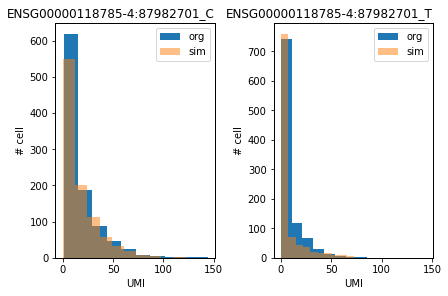

In [14]:
fig,ax = plt.subplots(ncols=2,sharex=True,constrained_layout=True)
for i, (idx, row) in enumerate(kpe.iterrows()):
    sim_data = np.array(simulated_data[i])
    org_data = ase_reform.loc[idx].astype(np.float32).values

    sim_kp = row[simulated_cols].values
    org_kp = row[cols].values
    ax[i].set_title(idx,loc='right')
    ax[i].set_xlabel('UMI')
    ax[i].set_ylabel('# cell')
    ax[i].hist(org_data,label='org')
    ax[i].hist(sim_data,label='sim',alpha=0.5)
    ax[i].legend()

In [15]:
from lib.variance import *
# simulate the expression with pb
cols = ['kon','koff','ksyn']
data = Parallel(n_jobs=cpu_count())(\
delayed(fun)(ase_reform.loc[idx].values, row[cols].values) for idx,row in kpe.iterrows())

add_cols = ['kon_mean','koff_mean', 'ksyn_mean',\
            'kon_lower','kon_upper','koff_lower','koff_upper','ksyn_lower','ksyn_upper']

kpe[add_cols] = data
out_file = out_prefix + '.est.var'
kpe.to_csv(outfile,float_format="%.5f")

In [16]:
print_cols = ['kon_mean','kon_lower','kon_upper',\
    'koff_mean','koff_lower','koff_upper',\
    'ksyn_mean','ksyn_lower','ksyn_upper']
kpe[print_cols].head()

,kon_mean,kon_lower,kon_upper,koff_mean,koff_lower,koff_upper,ksyn_mean,ksyn_lower,ksyn_upper
ENSG00000118785-4:87982701_C,0.943941,0.889076,0.994177,50.315229,46.746848,53.947516,913.501875,850.033685,981.547825
ENSG00000118785-4:87982701_T,0.152366,0.137963,0.166853,1.516761,1.329099,1.725575,77.413078,70.283739,85.576504


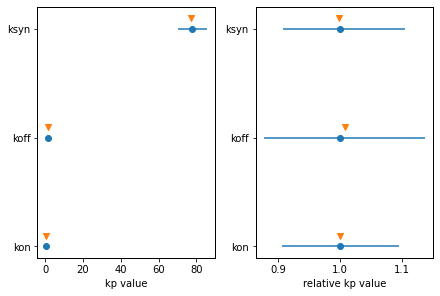

In [19]:
fig,ax = plt.subplots(constrained_layout=True, ncols=2)
allele = 'ENSG00000118785-4:87982701_T'

y=np.arange(len(cols))
kp_org   = ['kon','koff', 'ksyn']
kp_mean  = ['kon_mean','koff_mean', 'ksyn_mean']
kp_error = ['kon_lower','koff_lower','ksyn_lower','kon_upper','koff_upper','ksyn_upper',]

x_org = kpe.loc[allele, kp_org].values.reshape((1,-1))
x = kpe.loc[allele, kp_mean].values.reshape((1,-1))
x_error = kpe.loc[allele, kp_error].values.reshape((2, -1))
x_error_reform = abs(x_error - x)

ax[0].errorbar(x.reshape(-1), y, xerr=x_error_reform,fmt='o')
ax[0].scatter(x_org.reshape(-1), y+0.1, marker='v', color='#ff7f0e')
ax[0].set_xlabel('kp value')
ax[0].set_yticks(y)
ax[0].set_yticklabels(['kon','koff','ksyn'])

ax[1].errorbar(np.ones(len(cols)), y, xerr=x_error_reform/x,fmt='o')
ax[1].scatter(x_org/x, y+0.1, marker='v', color='#ff7f0e')
ax[1].set_xlabel('relative kp value')
ax[1].set_yticks(y)
ax[1].set_yticklabels(['kon','koff','ksyn'])

plt.show()
